# Models
In this notebook we propose different model architectures and generate predictions with each model.

In [26]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import numpy as np

In Notebook 2, we split the data so that the first 80% of the time series is used for training, while the remaining 20% is for validation. This prevents data leakage that could occur if the time series were randomly shuffled.

Additionally, factor features that theoretically depend on the target variable are not directly computed from the target for the validation set. Instead, to avoid data leakage, these features are estimated using a regression model, where we use seasonal features as predictors. We provide a detailed explanation of this process in Notebook 2.

In [27]:
data_path = "data/stickers/transformed_features.csv" # your features_df data path

def load_train_val_splits(data_path="data/transformed_df", target="num_sold"):
    df = pd.read_csv(data_path,index_col=0)
    df_numeric = df.select_dtypes(include=[float, int]).drop(columns=["id"]).dropna()

    train_df = df_numeric[df_numeric["test"] == 0]
    test_df = df_numeric[df_numeric["test"] == 1]

    X_train = train_df.drop(columns=[target,"test"])
    X_test = test_df.drop(columns=[target,"test"])

    y_train = train_df[target]
    y_test = test_df[target]
    
    return X_train, X_test, y_train, y_test # No shuffle, avoid data leakage in temporal data

X_train, X_val, y_train, y_val = load_train_val_splits(data_path=data_path)

In [28]:
# helper function to get testing metrics
def validate_model(model, X_val, y_val):

    # predictions
    y_pred = model.predict(X_val)
    
    # metrics
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    mape = mean_absolute_percentage_error(y_val,y_pred)
    
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R^2 Score: {r2}")
    print(f"Mean Absolute Percentage Error {mape}")
    
    return {"mse": mse, "mae": mae, "r2": r2, "mape":mape}

In [29]:
class BaggingEnsemble():
    '''Bagging ensemble model for regression.
    
    This class implements a bagging ensemble model for regression tasks. 
    It supports both hard and soft voting strategies, although only soft voting is implemented for regression.
    
    Attributes:
        voting (str): Voting strategy, either "hard" or "soft". Default is "hard".
        model_list (list): List of regression models to be used in the ensemble.
    '''
    
    def __init__(self, voting="hard", model_list=[]):
        self.model_list = model_list
        self.voting = voting
    
    def fit(self, X_train, y_train):
        '''
        Fits each model in the ensemble to the training data.
        '''
        for model in self.model_list:
            model.fit(X_train, y_train)
    
    def predict(self, X_test):
        '''
        Predicts the target variable for the test data using the ensemble of models.
        '''
        if self.voting == "soft":
            return np.mean([model.predict(X_test) for model in self.model_list], axis=0) # return the mean of all predictions
        elif self.voting == "hard":
            raise NotImplementedError("Hard voting not implemented for regression ensemble")
        else:
            raise ValueError("Unrecognized voting strategy: use hard or soft.")

## Linear regression
We start with the simplest regression model: linear regression. This should give a general notion of the quality of explanatory variables.

In [30]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [31]:
validate_model(model,X_val,y_val)

Mean Squared Error: 2464.9841925886126
Mean Absolute Error: 30.007544105590334
R^2 Score: 0.9930568539033481
Mean Absolute Percentage Error 0.5294148523363027


{'mse': 2464.9841925886126,
 'mae': 30.007544105590334,
 'r2': 0.9930568539033481,
 'mape': 0.5294148523363027}

## Ensemble Regression

Next, we propose a more sophisticated ensemble model. The first step is to fit a simple linear regression model that captures the overall trend in the data and computes the resulting residuals. We then train a second regression model using the same feature set but with these residuals as the target variable. This second model is designed to capture and correct nonlinear patterns and errors that the linear model fails to account for. The final prediction is obtained by summing the linear model’s prediction and the residuals predicted by the second model.

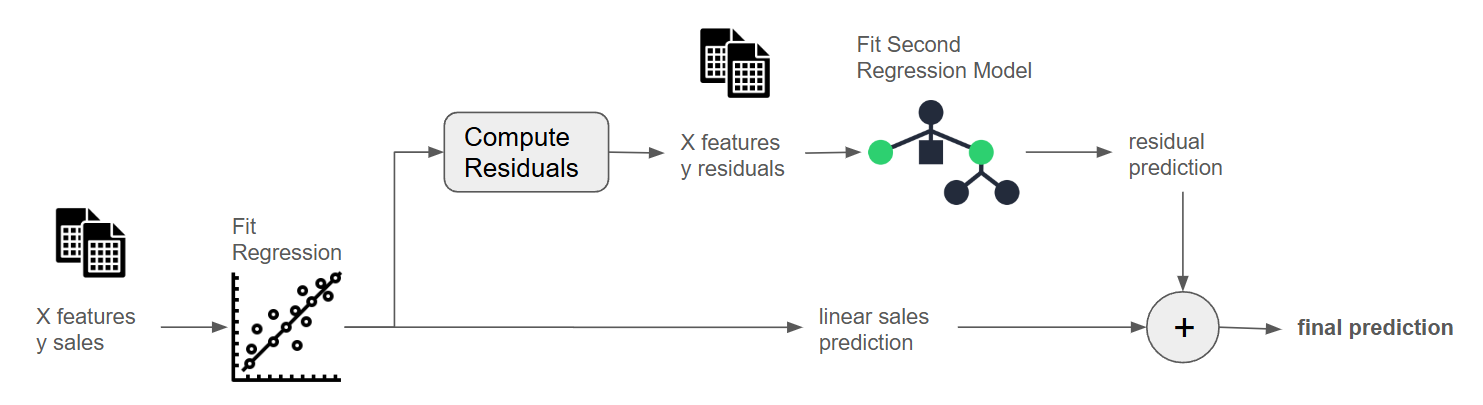

To justify the effectiveness of this ensemble approach, we should compare its performance against that of a single regressor. If a standalone model, such as XGBoost, performs well enough on its own, adding complexity may not be necessary. However, we hypothesize that the second model will improve performance by refining the initial predictions.

In [32]:
class EnsembleRegressionModel():
    '''Boost Ensemble Regression Model. 
    1. Fits a linear regression model with features X and target y, then calculates the resulting residuals.
    2. Fits another regression model with same feature set X and residuals as target variable (captures and corrects non linearities and errors from the first model).
    3. Computes the final prediction as the sum of the linear regression output and the residuals predicted by the second model.'''
    def __init__(self,top_model="xgboost",regressor="linear",regression_params={},top_model_params={},name=None):

        self.name=name # Add a verbous name for the model
        
        self.regression_params = regression_params
        self.top_model_params = top_model_params
        
        self.implemented_regressors = {
            "linear": LinearRegression,
            "svr":SVR
            # You can add other regression models here if desired. 
            # However, we highly recommend using linear regression, as it aligns with our feature engineering and insights, 
            # and also follows Occam's Razor (favoring simplicity).
        }
        self.regressor= self.implemented_regressors.get(regressor)
        
        self.implemented_top_models = {
            "xgboost":XGBRegressor,
            "random_forest":RandomForestRegressor,
            "bagging":BaggingEnsemble  # a custom ensemble model that computes the average of several models
            # here you can add other models to try (ej: transformer, random forest)
        }
        self.top_model=self.implemented_top_models.get(top_model)

        # Placeholders for the fitted models
        self.base_model = None
        self.top_model_instance = None
        
    def _train_regression(self,X, y):
        '''Trains the base linear regression model and computes residuals.'''
        self.base_model = self.regressor(**self.regression_params)
        self.base_model.fit(X, y)
        y_pred = self.base_model.predict(X)
        self.residuals = y - y_pred

    def _train_top_model(self,X):
        '''Trains the top model on the residuals from the linear regression.'''
        self.top_model_instance = self.top_model(**self.top_model_params)
        self.top_model_instance.fit(X, self.residuals)

    def fit(self,X_train,y_train):
        '''Trains both the base and residual models.'''
        self._train_regression(X_train, y_train)
        self._train_top_model(X_train)
    
    def predict(self,X_test):
        '''Makes predictions by summing the base regressor predictions and the residual model predictions.'''
        base_pred = self.base_model.predict(X_test)
        residual_pred = self.top_model_instance.predict(X_test)
        return base_pred + residual_pred
    
    def evaluate(self,X_test,y_test):
        '''Shows and returns regression metrics.'''
        y_pred = self.predict(X_test)
    
        # metrics
        mse = mean_squared_error(y_val, y_pred)
        mae = mean_absolute_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)
        mape = mean_absolute_percentage_error(y_val, y_pred)
        
        print(f"Mean Squared Error: {mse}")
        print(f"Mean Absolute Error: {mae}")
        print(f"R^2 Score: {r2}")
        print(f"Mean Absolute Percentage Error {mape}")
        
        return {"mse": mse, "mae": mae, "r2": r2, "mape":mape}


Here, we explore different model combinations. We begin with XGBoost, as it has consistently demonstrated strong performance in a wide range of scenarios and has been a top choice in many Kaggle competitions.

In [38]:
# try different model hyperparameters if desired

top_model_params = {
    "n_estimators": 100,
    "max_depth": 10,
    "learning_rate": 0.1,
    "random_state": 42
}

regression_params = {
    "fit_intercept": True,
}

my_boosting_model = EnsembleRegressionModel(top_model="xgboost",
                                            regressor="linear",
                                            regression_params=regression_params,
                                            top_model_params=top_model_params,
                                            name="xgboost_regression_ensemble" # just a verbous name to keep track predictions later
                                            )

my_boosting_model.fit(X_train,y_train) # training logic is already implemented within the class :)
my_boosting_model.evaluate(X_val,y_val)

Mean Squared Error: 44.005796501397086
Mean Absolute Error: 2.0223301986906597
R^2 Score: 0.9998760484245184
Mean Absolute Percentage Error 0.019231777907389398


{'mse': 44.005796501397086,
 'mae': 2.0223301986906597,
 'r2': 0.9998760484245184,
 'mape': 0.019231777907389398}

The following cell tests different model combinations and stores them in a list. The `get_model_predictions_df` function generates a DataFrame containing predictions from each model. We include a more in-depth evaluation and analysis od this predictions in the last Notebook (Notebook 4).

In [39]:
# SVR REGRESSOR + RANDOM FOREST
my_SVR_boosting_model = EnsembleRegressionModel(top_model="random_forest",
                                            regressor="svr",
                                            top_model_params=top_model_params,
                                            name="svr_regression_ensemble")


# LINEAR REGRESSION + CUSTOM BAGGING REGRESSOR
bagging_params = {
    "voting":"soft",
    "model_list": [XGBRegressor(),RandomForestRegressor()]
}

linear_bagging_model = EnsembleRegressionModel(top_model="bagging",
                                            regressor="linear",
                                            top_model_params=bagging_params,
                                            name="xgboost_rf_bagging_ensemble"
                                            )


# LINEAR REGRESSION + RANDOM FOREST REGRESSOR
top_model_params = {
    "n_estimators": 100,
    "max_depth": 10,
    "random_state": 42
}
my_rf_boosting_model = EnsembleRegressionModel(top_model="random_forest",
                                            regressor="linear",
                                            regression_params=regression_params,
                                            top_model_params=top_model_params,
                                            name="random_forest_regression_ensemble")




# Add single models to compare performance when we do not use ensmeble combination

xgboost_params = {
    "n_estimators": 100,
    "max_depth": 10,
    "learning_rate": 0.1,
    "random_state": 42
} # tune hyperparameters as you prefer

xgboost_basic = XGBRegressor(**xgboost_params)

linear_regression = LinearRegression()
decision_tree = DecisionTreeRegressor(max_depth=10)
bagging_model = BaggingEnsemble(voting="soft", model_list=[XGBRegressor(),RandomForestRegressor()])


# Model list
my_model_list = [
    my_boosting_model,
    my_rf_boosting_model,
    my_SVR_boosting_model,
    linear_bagging_model,
    # more models
    # you can also add other sklearn instances
    xgboost_basic,
    linear_regression,
    decision_tree,
    bagging_model 
]

## Generate Predictions Dataframe

In [ ]:
def get_model_predictions_df(model_list):
    pred_df = pd.DataFrame()
    for model in model_list:
        model.fit(X_train, y_train)
        predictions = model.predict(X_val)
        model_name = model.name if hasattr(model, 'name') else type(model).__name__
        pred_df[model_name] = predictions
        print("\n",model_name)
        validate_model(model=model,X_val=X_val,y_val=y_val)
    return pred_df

pred_df = get_model_predictions_df(my_model_list)
pred_df


 xgboost_regression_ensemble
Mean Squared Error: 44.005796501397086
Mean Absolute Error: 2.0223301986906597
R^2 Score: 0.9998760484245184
Mean Absolute Percentage Error 0.019231777907389398

 random_forest_regression_ensemble
Mean Squared Error: 99.52464762919183
Mean Absolute Error: 4.881506505919061
R^2 Score: 0.9997196679107375
Mean Absolute Percentage Error 0.04385179987041973


In [ ]:
# store predictions
predictions_path = "data/predictions_df.csv"
pred_df.to_csv(predictions_path)